# The Convolutional Classifier

A convnet used for image classification consists of two parts: a convolutional base and a dense head.

The base is used to extract the features from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The head is used to determine the class of the image. It is formed primarily of dense layers, but might include other layers like dropout.

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

## Training a Classifier
The goal of the network during training is to learn two things:

1. which features to extract from an image (base),
2. which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we reuse the base of a pretrained model. To the pretrained base we then attach an untrained head. In other words, we reuse the part of a network that has already learned to do 1. Extract features, and attach to it some fresh layers to learn 2. Classify.

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data.

Reusing a pretrained model is a technique known as transfer learning. It is so effective, that almost every image classifier these days will make use of it.

## Example - Train a Convnet Classifier
Throughout this course, we're going to be creating classifiers that attempt to solve the following problem: is this a picture of a Car or of a Truck? Our dataset is about 10,000 pictures of various automobiles, around half cars and half trucks.
### Step 1 - Load Data

In [7]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight = 'bold', titlesize=18, titlepad=10
      )
plt.rc('image', cmap='magma')
warnings.filterwarnings('ignore') # to clean up outputs cells

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    "train",
    labels = 'inferred',
    label_mode = 'binary',
    image_size = [128, 128],
    interpolation = 'nearest',
    batch_size = 64,
    shuffle = True
)

ds_valid_ = image_dataset_from_directory(
    "valid",
    labels = 'inferred',
    label_mode = 'binary',
    image_size = [128, 128],
    interpolation = 'nearest',
    batch_size = 64,
    shuffle = True
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


### Step 2 - Define Pretrained Base

The most commonly used dataset for pretraining is ImageNet, a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its applications module. The pretrained model we'll use is called VGG16.

In [9]:
pretrained_base = tf.keras.models.load_model(
    "cv-course-models/vgg16-pretrained-base"
)
pretrained_base.trainable = False

### Step 3- Attach Head
Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck. The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

### Step 4 - Train
Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of crossentropy and accuracy. The adam optimizer generally performs well, so we'll choose it as well.

In [12]:
model.compile(
    optimizer = "adam",
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30
)

Epoch 1/30
80/80 [==============================] - 352s 4s/step - loss: 0.5629 - binary_accuracy: 0.7166 - val_loss: 0.3734 - val_binary_accuracy: 0.8388
Epoch 2/30
80/80 [==============================] - 326s 4s/step - loss: 0.3481 - binary_accuracy: 0.8546 - val_loss: 0.3396 - val_binary_accuracy: 0.8557
Epoch 3/30
80/80 [==============================] - 326s 4s/step - loss: 0.2984 - binary_accuracy: 0.8818 - val_loss: 0.3265 - val_binary_accuracy: 0.8626
Epoch 4/30
80/80 [==============================] - 330s 4s/step - loss: 0.2657 - binary_accuracy: 0.8989 - val_loss: 0.3210 - val_binary_accuracy: 0.8662
Epoch 5/30
80/80 [==============================] - 329s 4s/step - loss: 0.2401 - binary_accuracy: 0.9105 - val_loss: 0.3176 - val_binary_accuracy: 0.8658
Epoch 6/30
80/80 [==============================] - 329s 4s/step - loss: 0.2183 - binary_accuracy: 0.9229 - val_loss: 0.3139 - val_binary_accuracy: 0.8683
Epoch 7/30
80/80 [==============================] - 329s 4s/step - los

When training a neural network, it's always a good idea to examine the loss and metric plots. The history object contains this information in a dictionary history.history. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

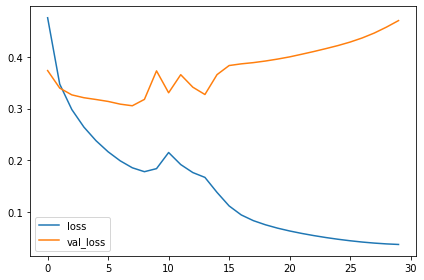

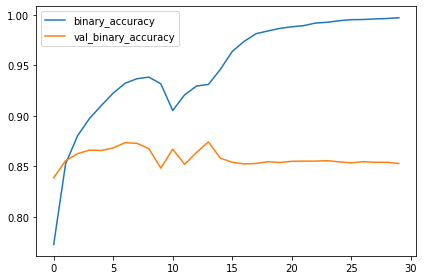

In [14]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## Conclusion
In this lesson, we learned about the structure of a convnet classifier: a head to act as a classifier atop of a base which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about in the introductory course. For features, it uses those features extracted by the base. This is the basic idea behind convolutional classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

For the next few lessons, we'll take a look at how the convolutional base accomplishes the feature extraction. Then, you'll learn how to apply these ideas and design some classifiers of your own.